In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from dask.distributed import Client, progress
import os
import netCDF4 as nc
from glob import glob
from clef.code import *
import matplotlib.pyplot as plt

# Defining dictionaries to set up search and calculations

In [2]:
pCO2 = {'model': 'ACCESS-ESM1-5',
        'var_id': 'spco2', #Surface Aqueous Partial Pressure of CO2 [Pa] - only surface available
        'exp': 'historical', 
        'exp_future': 'esm-ssp585',
        'variant': 'r10i1p1f1',
        'freq': 'mon',
        'long_name': 'partial CO2 pressure at surface', 
        'short_name': 'pCO2'}

#This dictionary contains the time periods of interest
periods_interest = {'p1': np.arange(1890, 1911, 10),
                    'p2': np.arange(1940, 1961, 10),
                    'p3': np.arange(2000, 2021, 10),
                    'p4': np.arange(2040, 2061, 10),
                    'p5': np.arange(2090, 2101, 10)}

# Loading mask

In [26]:
#Loading mask
mask = xr.load_dataarray('MEASO_3Dmask.nc')

#Applying mask
#Getting region names from mask
regionNames = sorted(set(mask.region.values))

#Subsetting shapefiles into regions
#Initialise dictionary that will contain sector limits
mask_reg = {}

#Saving each sector as an entry in the dictionary
for reg in regionNames:
    mask_reg[f"{reg}"] = mask.sel(region = reg)

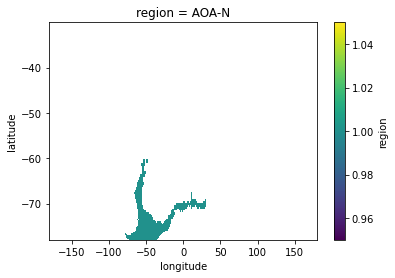

In [10]:
mask_reg['AOA-N'].plot()

# Searching and loading data for variable of interest

In [3]:
#Create a session in CLEF to access CMIP6 data
db = connect()
s = Session()

#Define search parameters for CLEF
search_dict = {'variable_id': pCO2['var_id'], 
               'model': pCO2['model'], 
               'frequency': pCO2['freq'], 
              'experiment_id': pCO2['exp'],
               'variant_label': pCO2['variant']}

#Perform search
df = search(s, project = 'CMIP6', latest = True, **search_dict)

In [4]:
filenames = sorted(glob(os.path.join(df['path'][0], '*.nc')))
filenames

['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Omon/spco2/gn/v20200605/spco2_Omon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc']

In [5]:
varInt = xr.open_dataset(filenames[0], mask_and_scale = True).spco2
varInt = varInt.sel(time = slice('1890-07', '1910-06'))
varInt

<xarray.DataArray 'spco2' (time: 240, j: 300, i: 360)>
[25920000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1890-07-16T12:00:00 ... 1910-06-16
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
    depth      float64 ...
Attributes:
    standard_name:  surface_partial_pressure_of_carbon_dioxide_in_sea_water
    long_name:      Surface Aqueous Partial Pressure of CO2
    comment:        The surface called 'surface' means the lower boundary of ...
    units:          Pa
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2020-06-05T05:20:01Z altered by CMOR: Treated scalar dime...

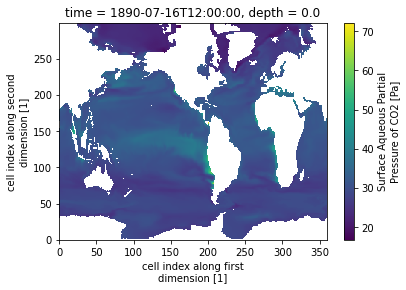

In [12]:
varInt[0].plot()

# Replacing indexes with latitude and longitude values

In [6]:
def corrlong(array):
    '''
    Inputs:
    array - Data array on which longitude corrections will be applied.
    
    Output:
    Data array with corrected longitude values.
    '''
    
    #Making a deep copy of original longitude values in the array being corrected
    lon = array['longitude'][0].values
    
    #Values changed from 0-360 to between -180 and +180.
    lon[np.where(lon > 180)] = lon[np.where(lon >180)]-360
    
    #Assigning corrected longitudes and latitude values to i and j, which are index based
    array.coords['i'] = lon
    array.coords['j'] = array['latitude'][:,0].values
    
    #Removing latitude and longitude dimensions and renaming i and j dimensions
    array = array.drop(('latitude', 'longitude'))
    array = array.rename(({'i':'longitude', 'j':'latitude'}))
    
    #Longitude values must be sorted from smallest to largest prior to plotting
    array = array.sortby(array.longitude)
    
    return array

In [7]:
var_corr = corrlong(varInt)
var_corr = var_corr.sel(latitude = slice(-90, -30))
var_corr

<xarray.DataArray 'spco2' (time: 240, latitude: 77, longitude: 360)>
[6652800 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1890-07-16T12:00:00 ... 1910-06-16
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    depth      float64 0.0
Attributes:
    standard_name:  surface_partial_pressure_of_carbon_dioxide_in_sea_water
    long_name:      Surface Aqueous Partial Pressure of CO2
    comment:        The surface called 'surface' means the lower boundary of ...
    units:          Pa
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2020-06-05T05:20:01Z altered by CMOR: Treated scalar dime...

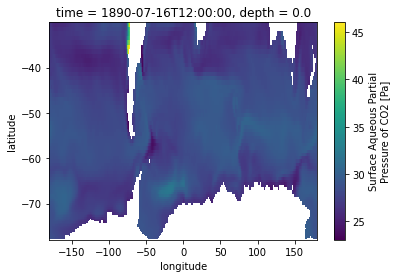

In [16]:
var_corr[0].plot()

Now the mask and the data from ACCESS-ESM1.5 match and I should be able to apply a mask.

# Apply mask
I have randomly selected one sector as an example.

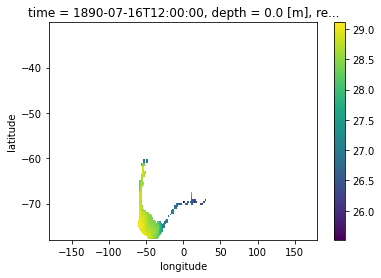

In [29]:
#This gives me an error
# mask_reg['AOA-N']['latitude'] = np.round(mask_reg['AOA-N'].latitude, 4)

# masked_var = var_corr*mask_reg['AOA-N']
masked_var[0].plot()

In [18]:
#This does not give me an error, but the result is a blank data array
var_corr = var_corr.load()
masked_var = var_corr*mask_reg['AOA-N']
masked_var

<xarray.DataArray (time: 240, latitude: 0, longitude: 360)>
array([], shape=(240, 0, 360), dtype=float64)
Coordinates:
  * latitude   (latitude) float64 
  * time       (time) datetime64[ns] 1890-07-16T12:00:00 ... 1910-06-16
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    depth      float64 0.0
    region     <U5 'AOA-N'

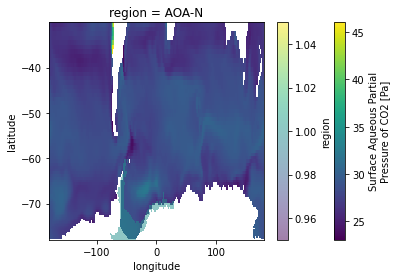

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

#But the loaded data array does have values
var_corr[0].plot(ax = ax)

#and when the mask is overlaid, it shows in the right place
mask_reg['AOA-N'].plot(ax = ax, alpha = 0.5)

# Loading data with a different engine

In [33]:
# This gives me an error
varInt_scipy = xr.open_dataset(filenames[0], engine = 'scipy')

TypeError: Error: /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Omon/spco2/gn/v20200605/spco2_Omon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc is not a valid NetCDF 3 file
            If this is a NetCDF4 file, you may need to install the
            netcdf4 library, e.g.,

            $ pip install netcdf4
            

In [19]:
#Loading mask
mask_2d = xr.load_dataarray('MEASO_2Dmask.nc')
mask_2d['latitude'] = np.round(mask_2d.latitude, 4)

In [20]:
var_corr['latitude'] = np.round(var_corr.latitude, 4)
mask_var = xr.where(mask_2d == 1, var_corr, np.nan)
mask_var

<xarray.DataArray (latitude: 77, longitude: 360, time: 240)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[28.743713, 28.929344, 29.110775, ..., 27.248503, 28.056774,
         28.511839],
        [28.67487 , 28.851173, 29.020672, ..., 27.060738, 27.983706,
         28.460537],
        [28.603306, 28.76184 , 28.913404, ..., 26.887384, 27.890577,
         28.40599 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 1890-07-16T12:00:00 ... 1910-06-16
    depth      float64 0.0

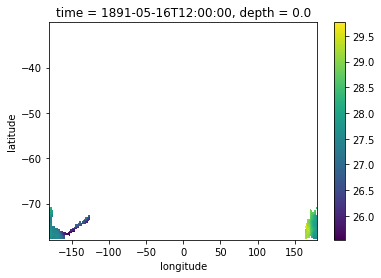

In [24]:
mask_var[...,10].plot()